In [1]:
!nvidia-smi

Fri May 31 16:53:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

from huggingface_hub import notebook_login, logging
import wandb

2024-05-31 16:53:53.386715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:53:53.386765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:53:53.388181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
try:
    from google.colab import drive
    import os

    print("Using Google Colab")
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SQL-Query-Generator/')
    
    notebook_login()
    logging.set_verbosity(logging.CRITICAL)
    wandb.login()
        
except ModuleNotFoundError:
    notebook_login()
    logging.set_verbosity(logging.CRITICAL)
    wandb.login()
    print("Using other environment")

Using other environment


In [6]:
def get_data():
    dataset = load_dataset("NickyNicky/medical_mtsamples", split='train')
    return pd.DataFrame(dataset)

def preprocess_data(texts, labels):
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.2, stratify=labels
    )
    return train_texts, val_texts, train_labels, val_labels

def tokenize_function(texts, tokenizer):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

def train_and_evaluate_model(model_name, train_dataset, val_dataset, num_labels):
    class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset.labels), y=train_dataset.labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir=f'./results_{model_name}',
        num_train_epochs=30,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'./logs_{model_name}',
        logging_steps=10,
        evaluation_strategy='epoch',
        save_strategy='epoch', 
        push_to_hub=True, 
        hub_model_id= model_name.split("/")[-1] + "-medical-text-classification",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_total_limit=3,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()
    trainer.push_to_hub()

    metrics = trainer.evaluate()
    print(f"Metrics for {model_name}:")
    print(metrics)
    
    return trainer, metrics

def plot_curves(val_labels, preds, probs, num_classes, model_name):
    cm = confusion_matrix(val_labels, preds)
    report = classification_report(val_labels, preds)

    print(f"Confusion Matrix for {model_name}:")
    print(cm)
    print(f"\nClassification Report for {model_name}:")
    print(report)

    if num_classes > 1:
        val_labels_binarized = label_binarize(val_labels, classes=range(num_classes))

        roc_auc = {}
        fpr = {}
        tpr = {}
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(val_labels_binarized[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(20, 20))
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

        precision = {}
        recall = {}
        pr_auc = {}
        for i in range(num_classes):
            precision[i], recall[i], _ = precision_recall_curve(val_labels_binarized[:, i], probs[:, i])
            pr_auc[i] = auc(recall[i], precision[i])
            
        plt.figure(figsize=(20, 20))
        for i in range(num_classes):
            plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of class {i} (area = {pr_auc[i]:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print(f"Not enough classes in validation set to compute ROC AUC and PR curves for {model_name}.")
    
def main(model_name):
    data = get_data()
    texts = data['transcription'].astype(str).tolist()
    labels = data['medical_specialty'].astype('category').cat.codes.tolist()
    num_labels = len(set(labels))

    train_texts, val_texts, train_labels, val_labels = preprocess_data(texts, labels)

    results = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_encodings = tokenize_function(train_texts, tokenizer)
    val_encodings = tokenize_function(val_texts, tokenizer)

    train_dataset = Dataset(train_encodings, train_labels)
    val_dataset = Dataset(val_encodings, val_labels)

    trainer, metrics = train_and_evaluate_model(model_name, train_dataset, val_dataset, num_labels)

    val_preds = trainer.predict(val_dataset)
    preds = val_preds.predictions.argmax(-1)
    probs = torch.nn.functional.softmax(torch.tensor(val_preds.predictions), dim=-1).numpy()

    plot_curves(val_labels, preds, probs, num_labels, model_name)

    results.append((model_name, metrics))

    for model_name, metrics in results:
        print(f"\nMetrics for {model_name}:")
        print(metrics)

In [7]:
models = [
    'medicalai/ClinicalBERT',
    'emilyalsentzer/Bio_ClinicalBERT',
    'nlpie/tiny-clinicalbert',
    'nlpie/distil-clinicalbert',
    'nlpie/clinical-miniALBERT-312'
]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for medicalai/ClinicalBERT:
{'eval_loss': 1.813850998878479, 'eval_accuracy': 0.302, 'eval_precision': 0.26157330779892174, 'eval_recall': 0.302, 'eval_f1': 0.2729449719317237, 'eval_runtime': 4.3813, 'eval_samples_per_second': 228.242, 'eval_steps_per_second': 14.379, 'epoch': 6.0}
Confusion Matrix for medicalai/ClinicalBERT:
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 95  1]
 [ 0  0  0 ...  0 23  1]]

Classification Report for medicalai/ClinicalBERT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.26      0.38      0.31        74
           4       0.00      0.00      0.00         3
           5       0.22      0.23      0.22       103
           6       0.00      0.00      0.00         5
           7       0.00

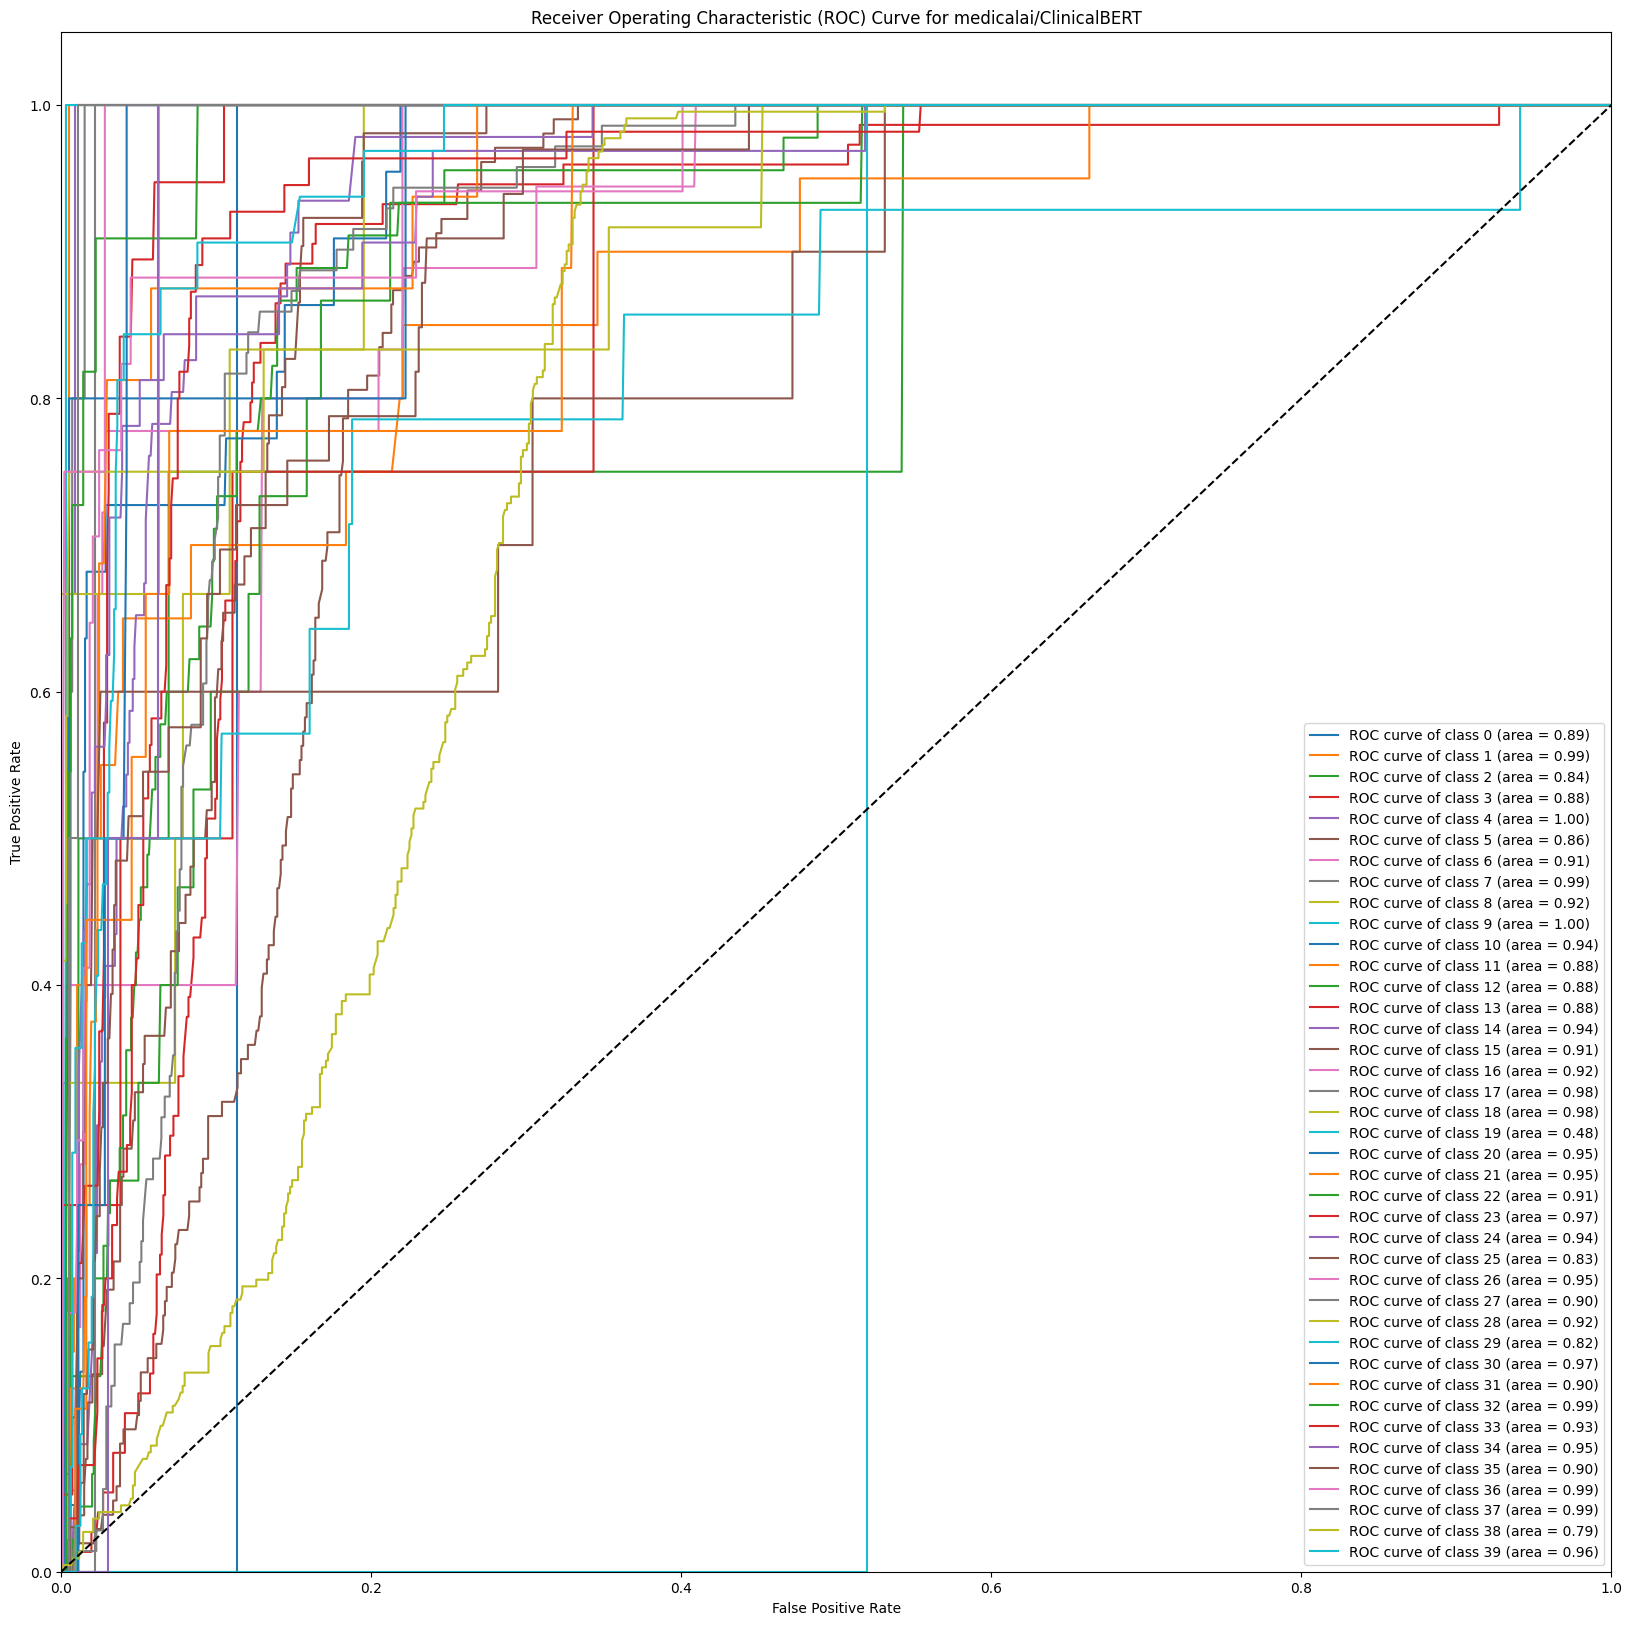

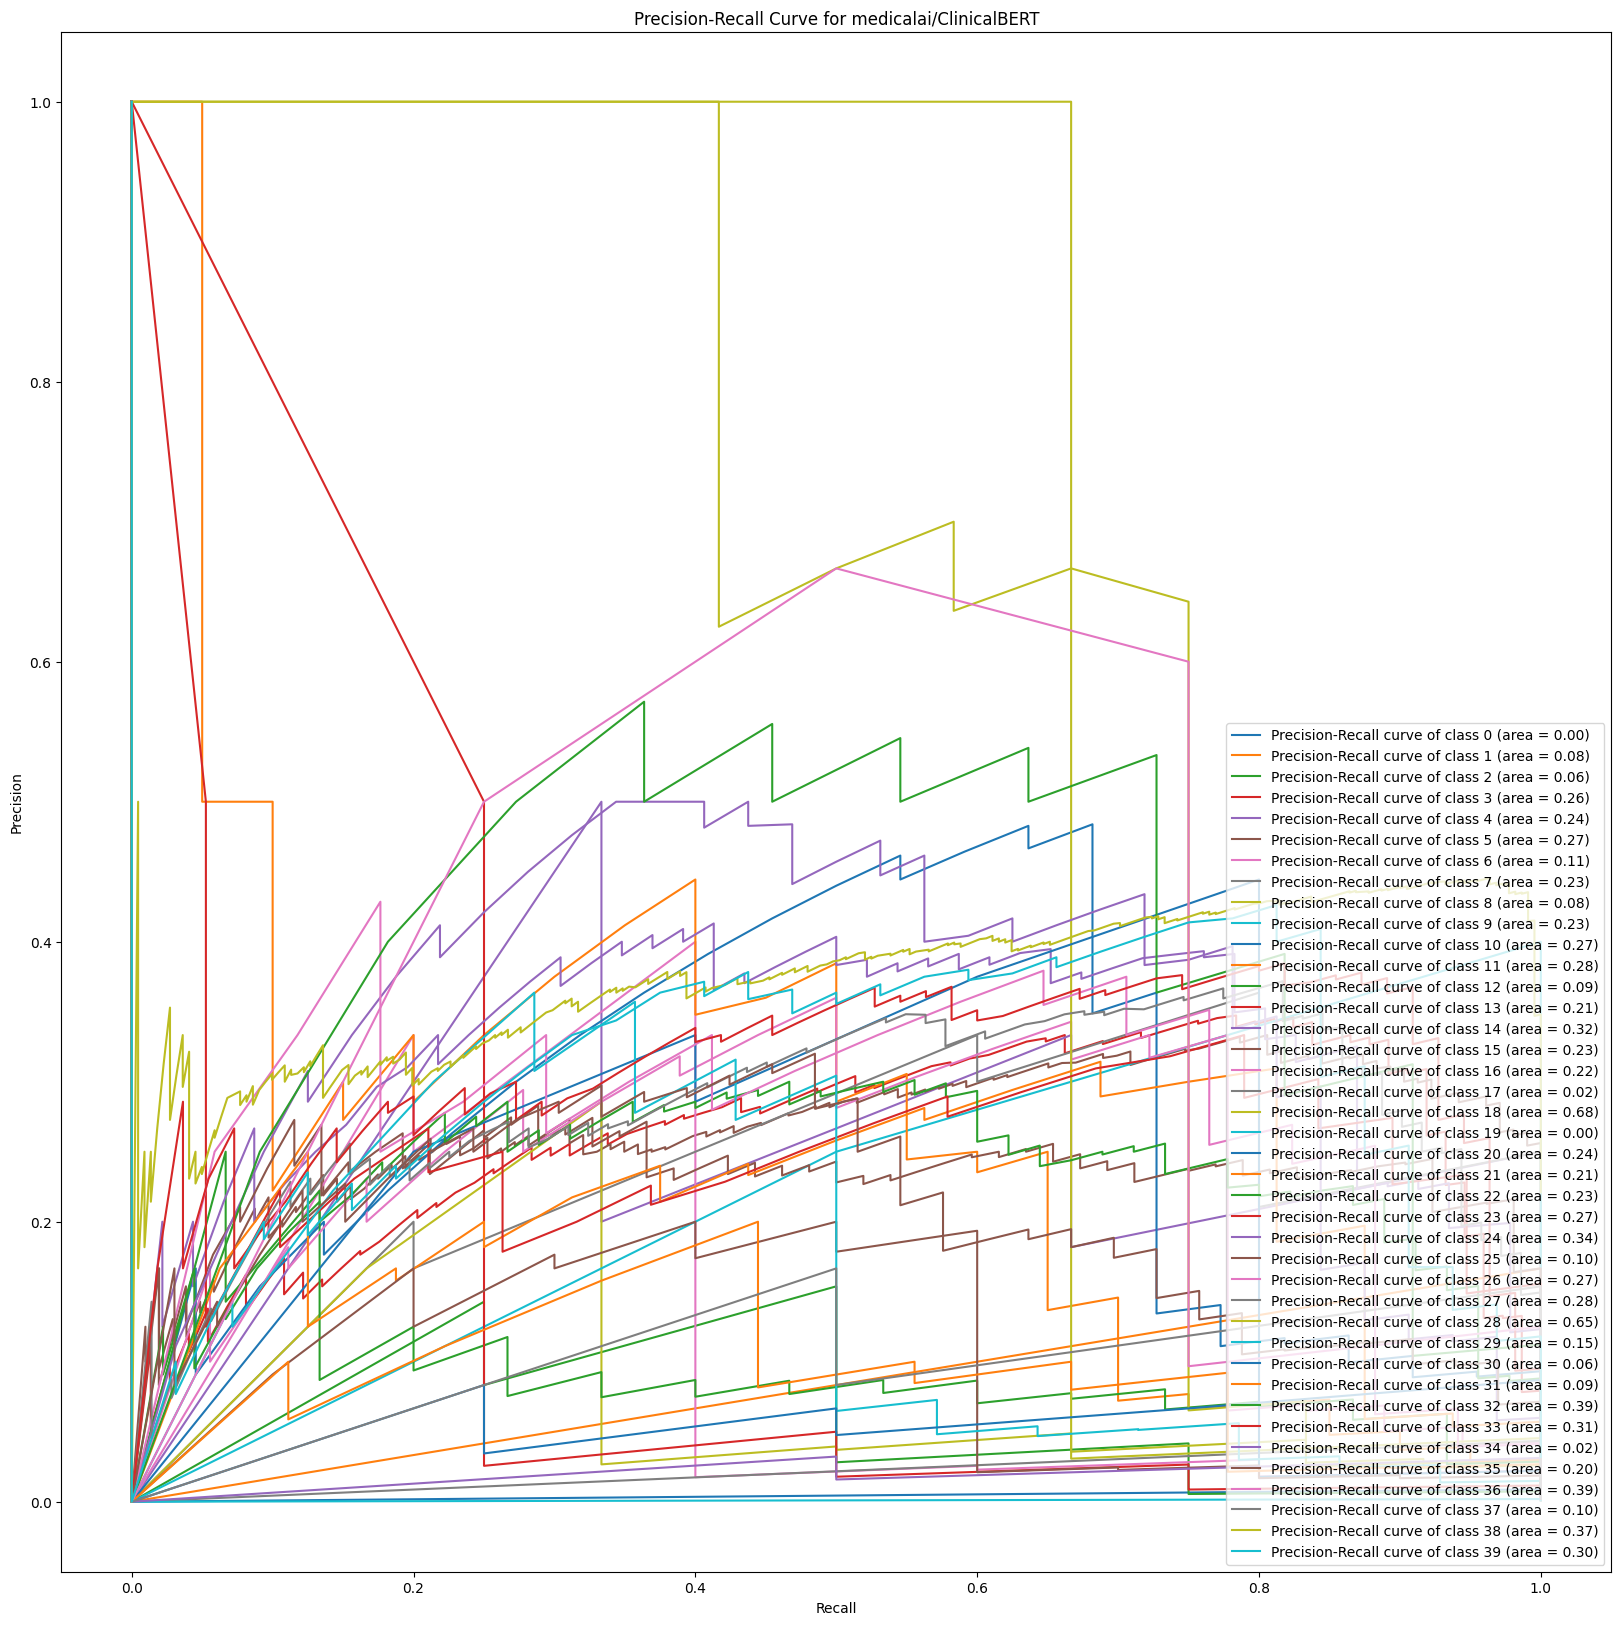


Metrics for medicalai/ClinicalBERT:
{'eval_loss': 1.813850998878479, 'eval_accuracy': 0.302, 'eval_precision': 0.26157330779892174, 'eval_recall': 0.302, 'eval_f1': 0.2729449719317237, 'eval_runtime': 4.3813, 'eval_samples_per_second': 228.242, 'eval_steps_per_second': 14.379, 'epoch': 6.0}


In [8]:
if __name__ == "__main__":
    main("medicalai/ClinicalBERT")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for emilyalsentzer/Bio_ClinicalBERT:
{'eval_loss': 1.7678487300872803, 'eval_accuracy': 0.325, 'eval_precision': 0.2949929131924876, 'eval_recall': 0.325, 'eval_f1': 0.2956966528900227, 'eval_runtime': 5.5935, 'eval_samples_per_second': 178.778, 'eval_steps_per_second': 11.263, 'epoch': 6.0}
Confusion Matrix for emilyalsentzer/Bio_ClinicalBERT:
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 86 20]
 [ 0  0  0 ...  0  3 24]]

Classification Report for emilyalsentzer/Bio_ClinicalBERT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.38      0.53      0.44        74
           4       0.00      0.00      0.00         3
           5       0.30      0.40      0.34       103
           6       0.00      0.00      0.00       

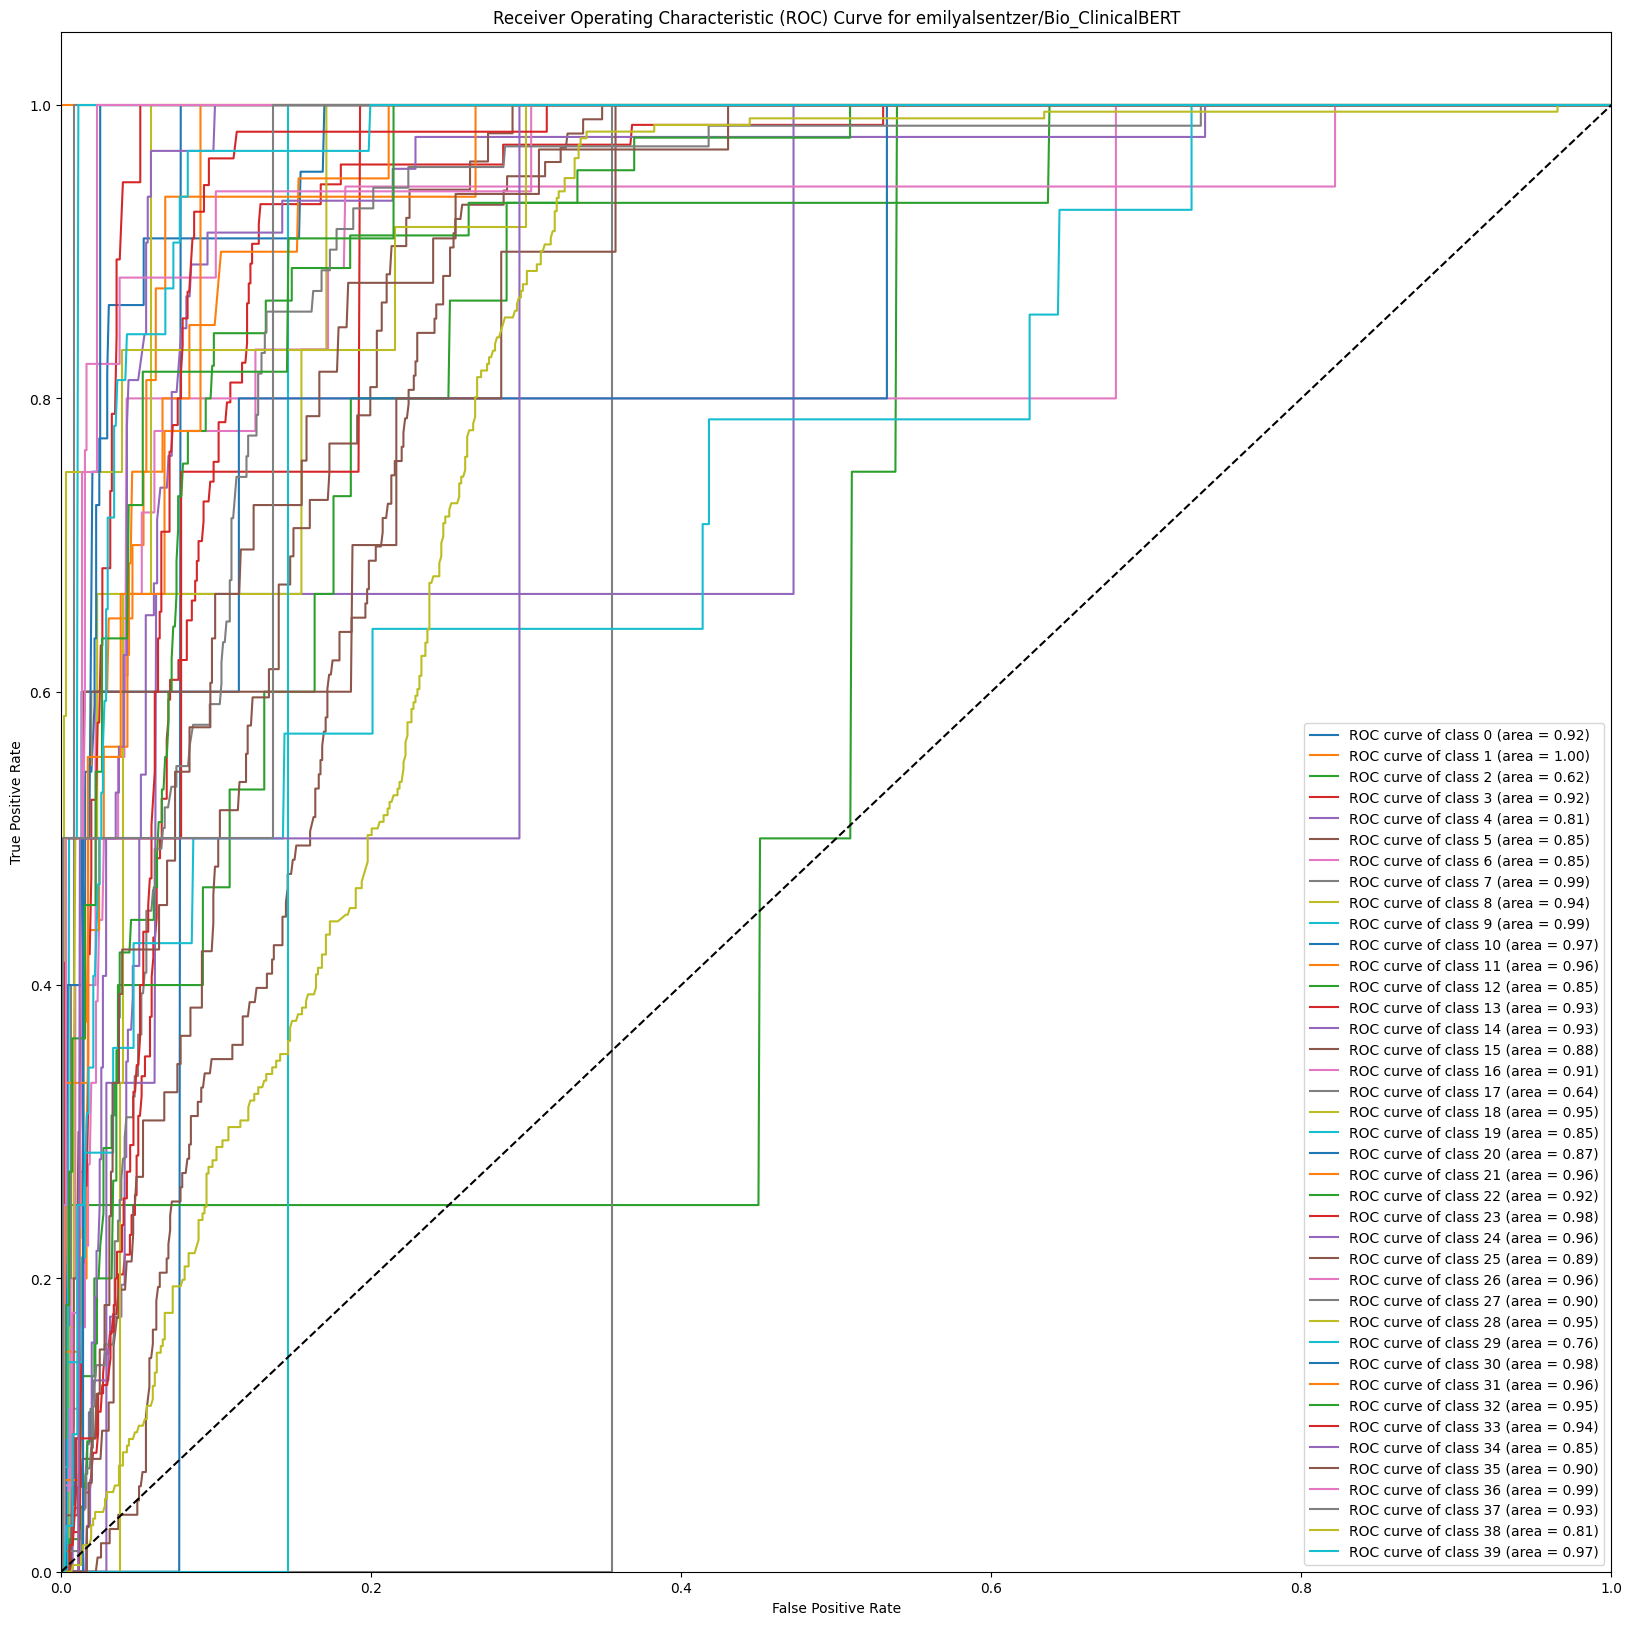

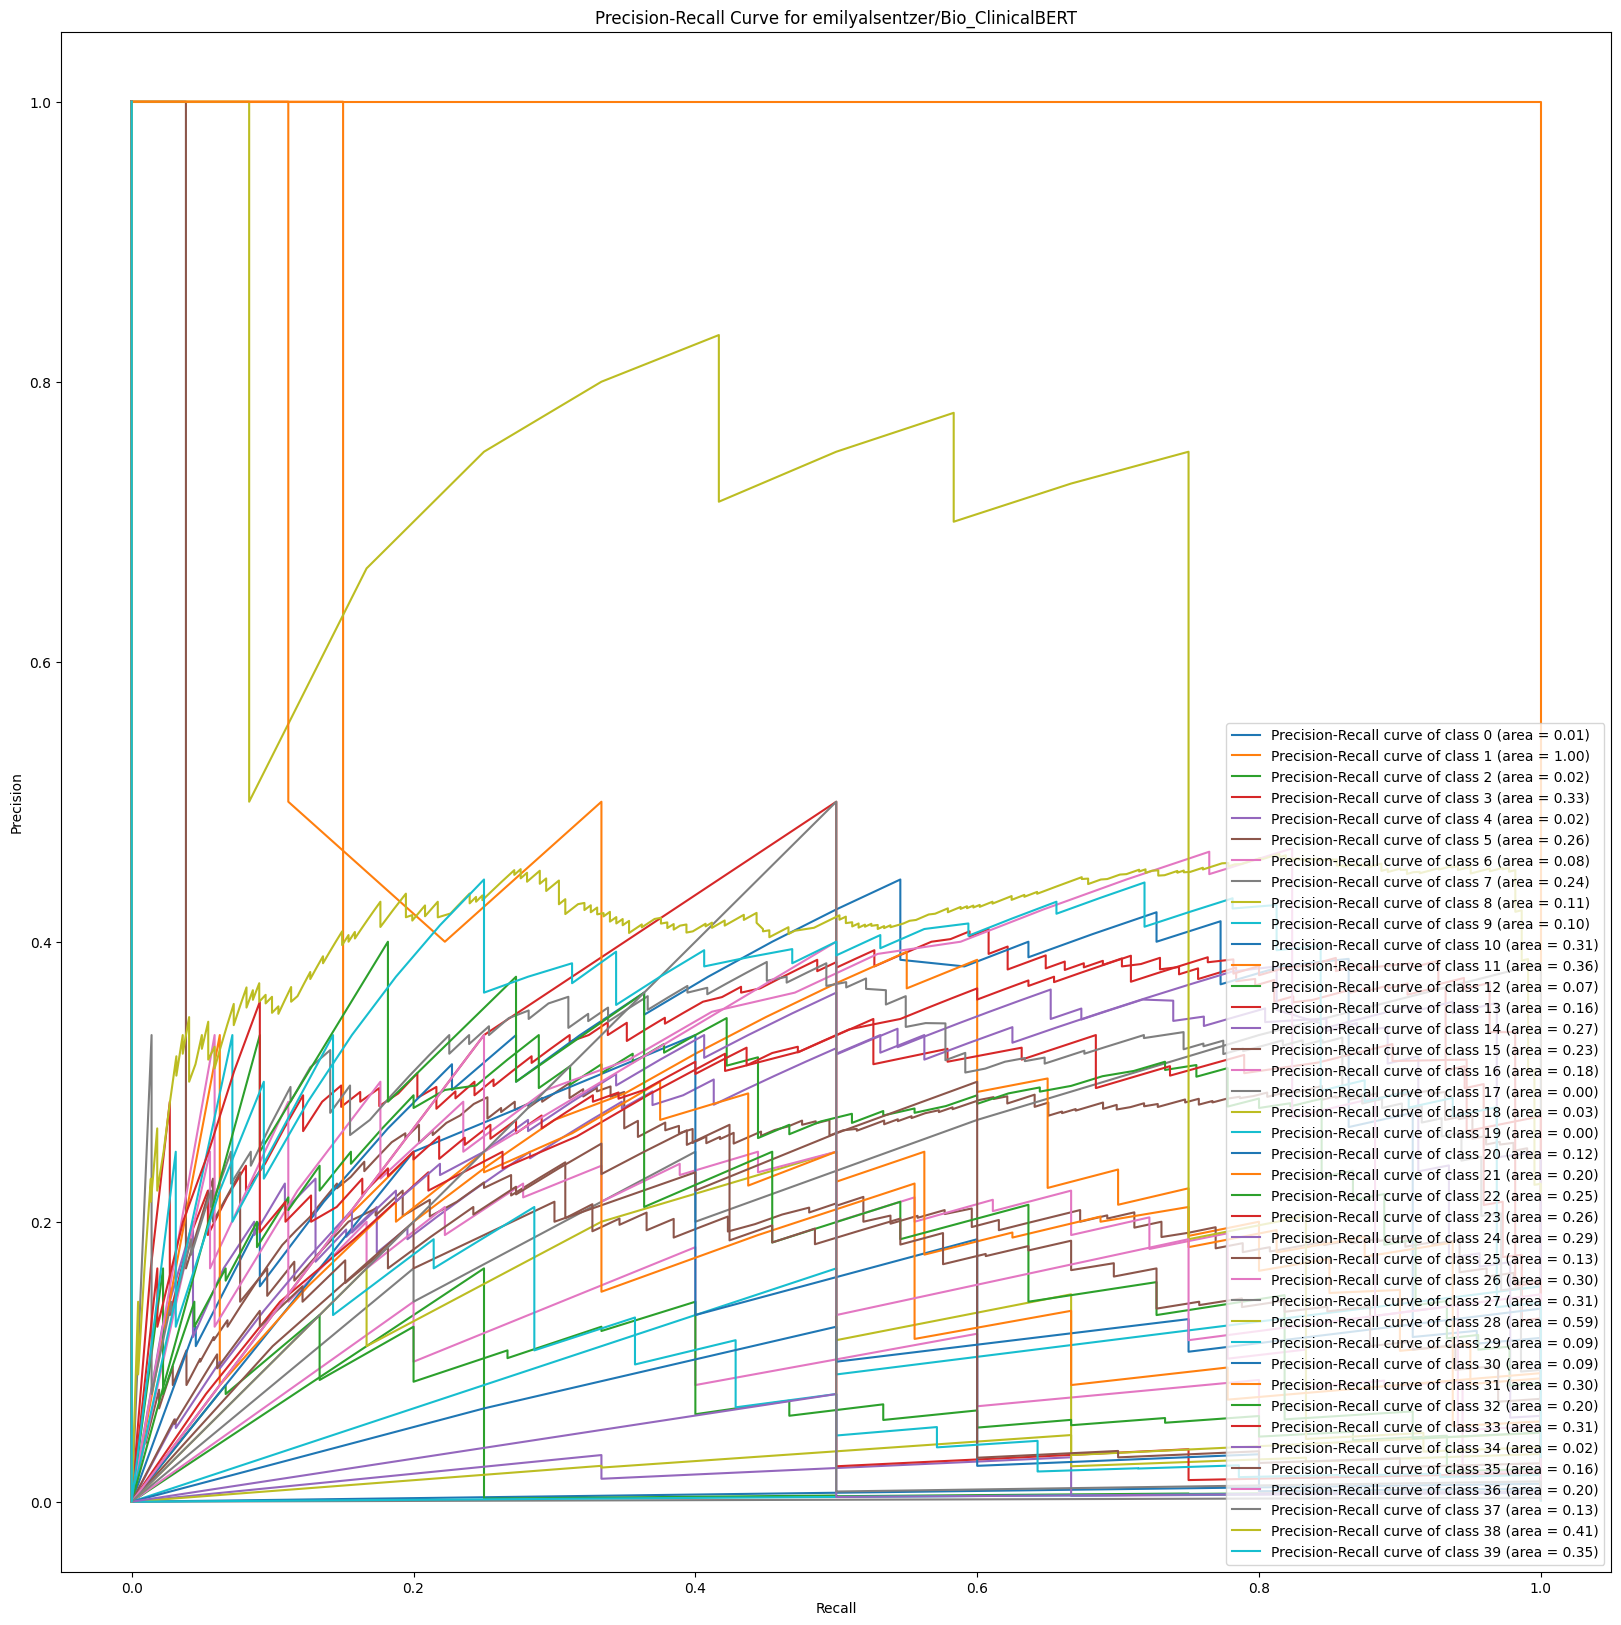


Metrics for emilyalsentzer/Bio_ClinicalBERT:
{'eval_loss': 1.7678487300872803, 'eval_accuracy': 0.325, 'eval_precision': 0.2949929131924876, 'eval_recall': 0.325, 'eval_f1': 0.2956966528900227, 'eval_runtime': 5.5935, 'eval_samples_per_second': 178.778, 'eval_steps_per_second': 11.263, 'epoch': 6.0}


In [9]:
if __name__ == "__main__":
    main('emilyalsentzer/Bio_ClinicalBERT')

tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/55.6M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for nlpie/tiny-clinicalbert:
{'eval_loss': 2.117561101913452, 'eval_accuracy': 0.256, 'eval_precision': 0.2149398367727997, 'eval_recall': 0.256, 'eval_f1': 0.21967643713359233, 'eval_runtime': 1.2085, 'eval_samples_per_second': 827.49, 'eval_steps_per_second': 52.132, 'epoch': 13.0}
Confusion Matrix for nlpie/tiny-clinicalbert:
[[  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   2   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 120   2]
 [  0   0   0 ...   0  23   1]]

Classification Report for nlpie/tiny-clinicalbert:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         4
           3       0.25      0.32      0.28        74
           4       0.00      0.00      0.00         3
           5       0.21      0.37      0.27       103
           6       0.00      0.00     

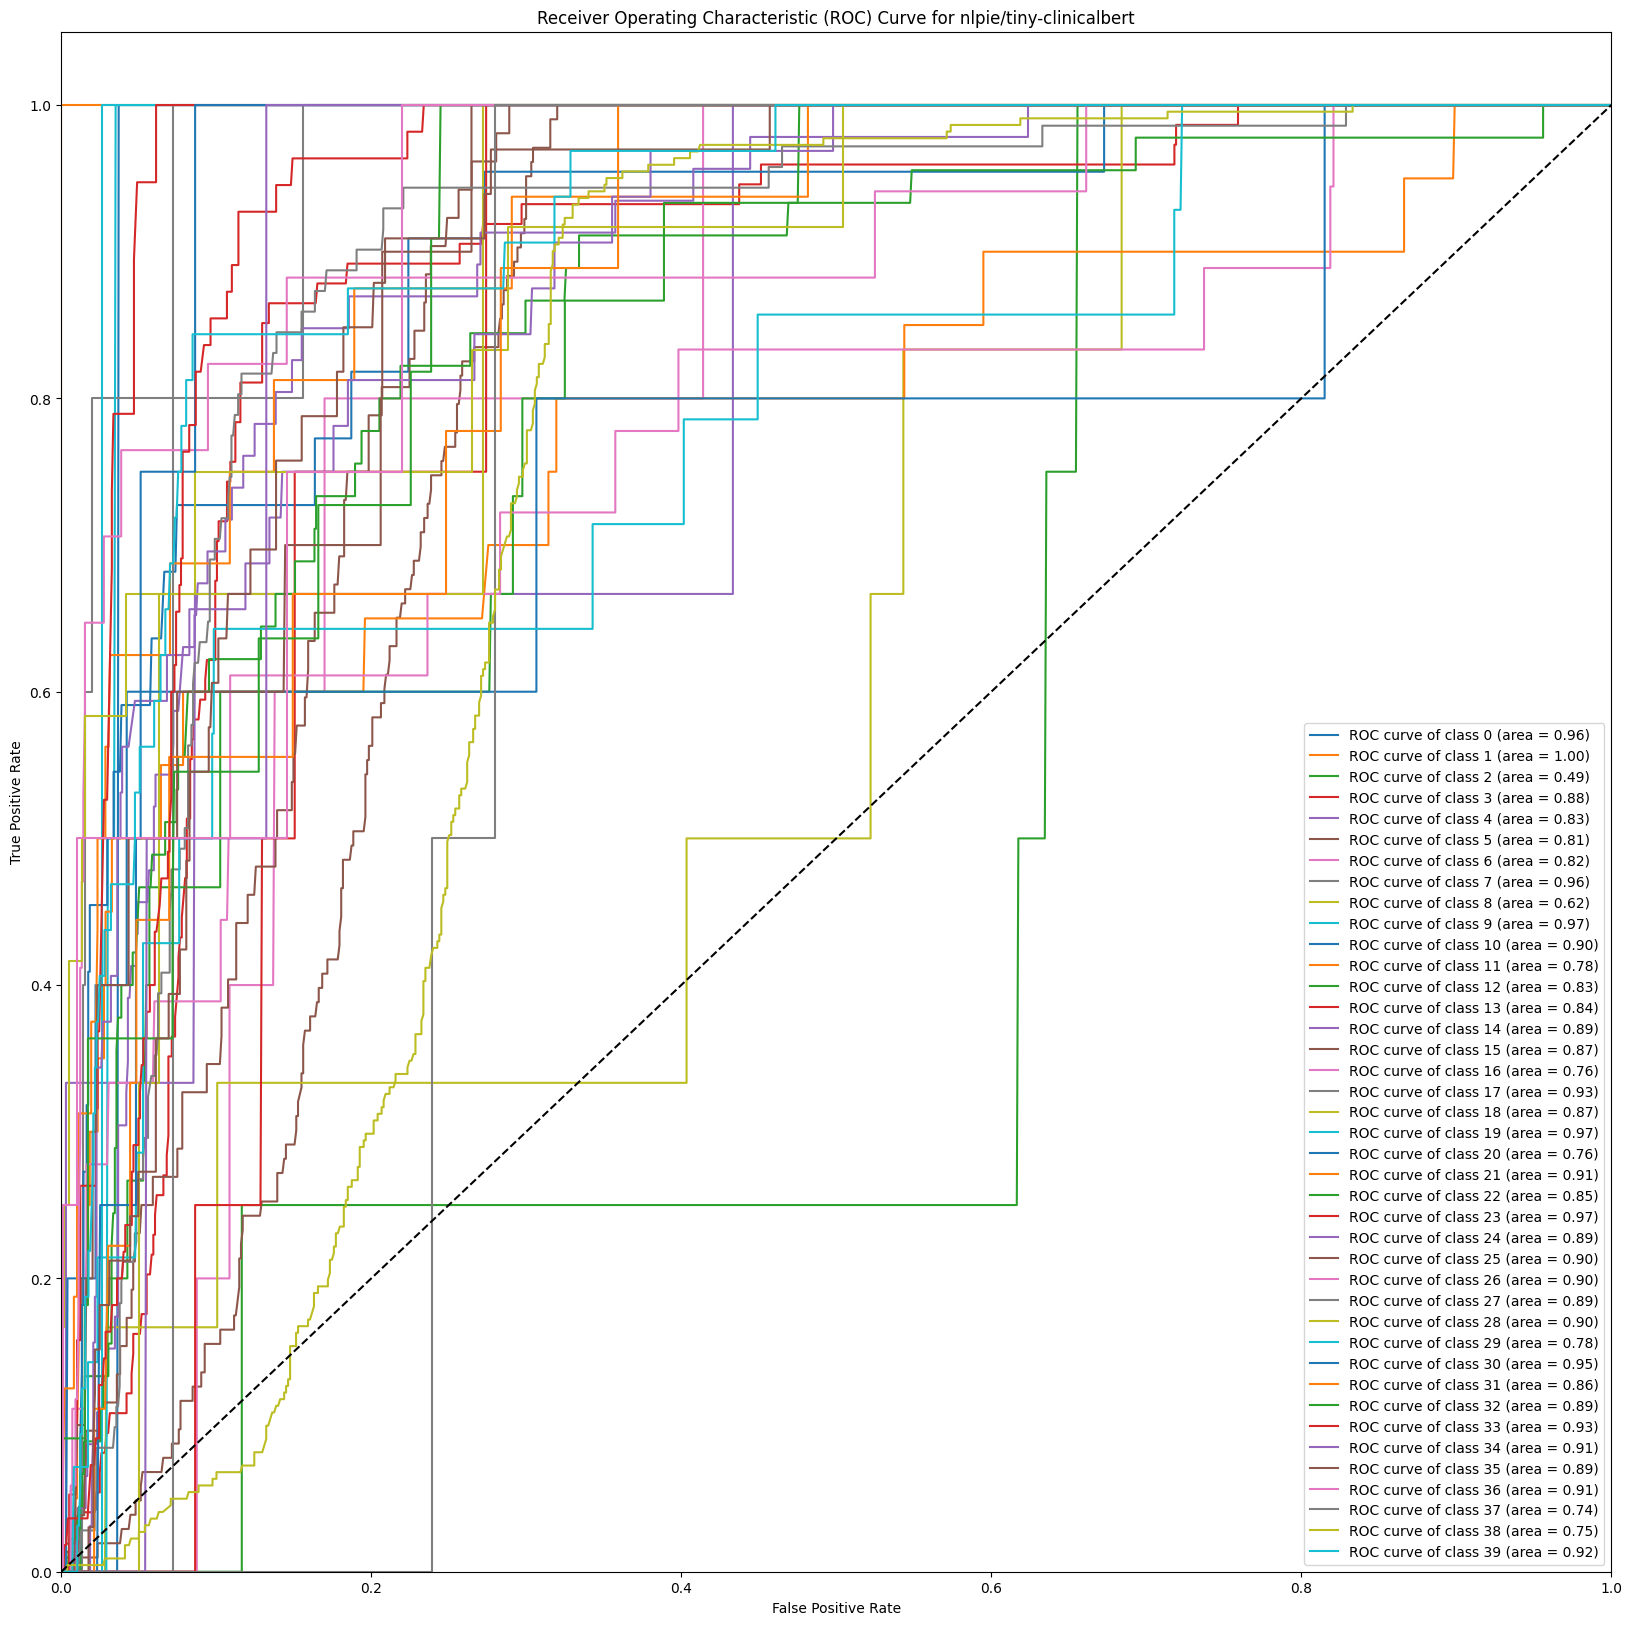

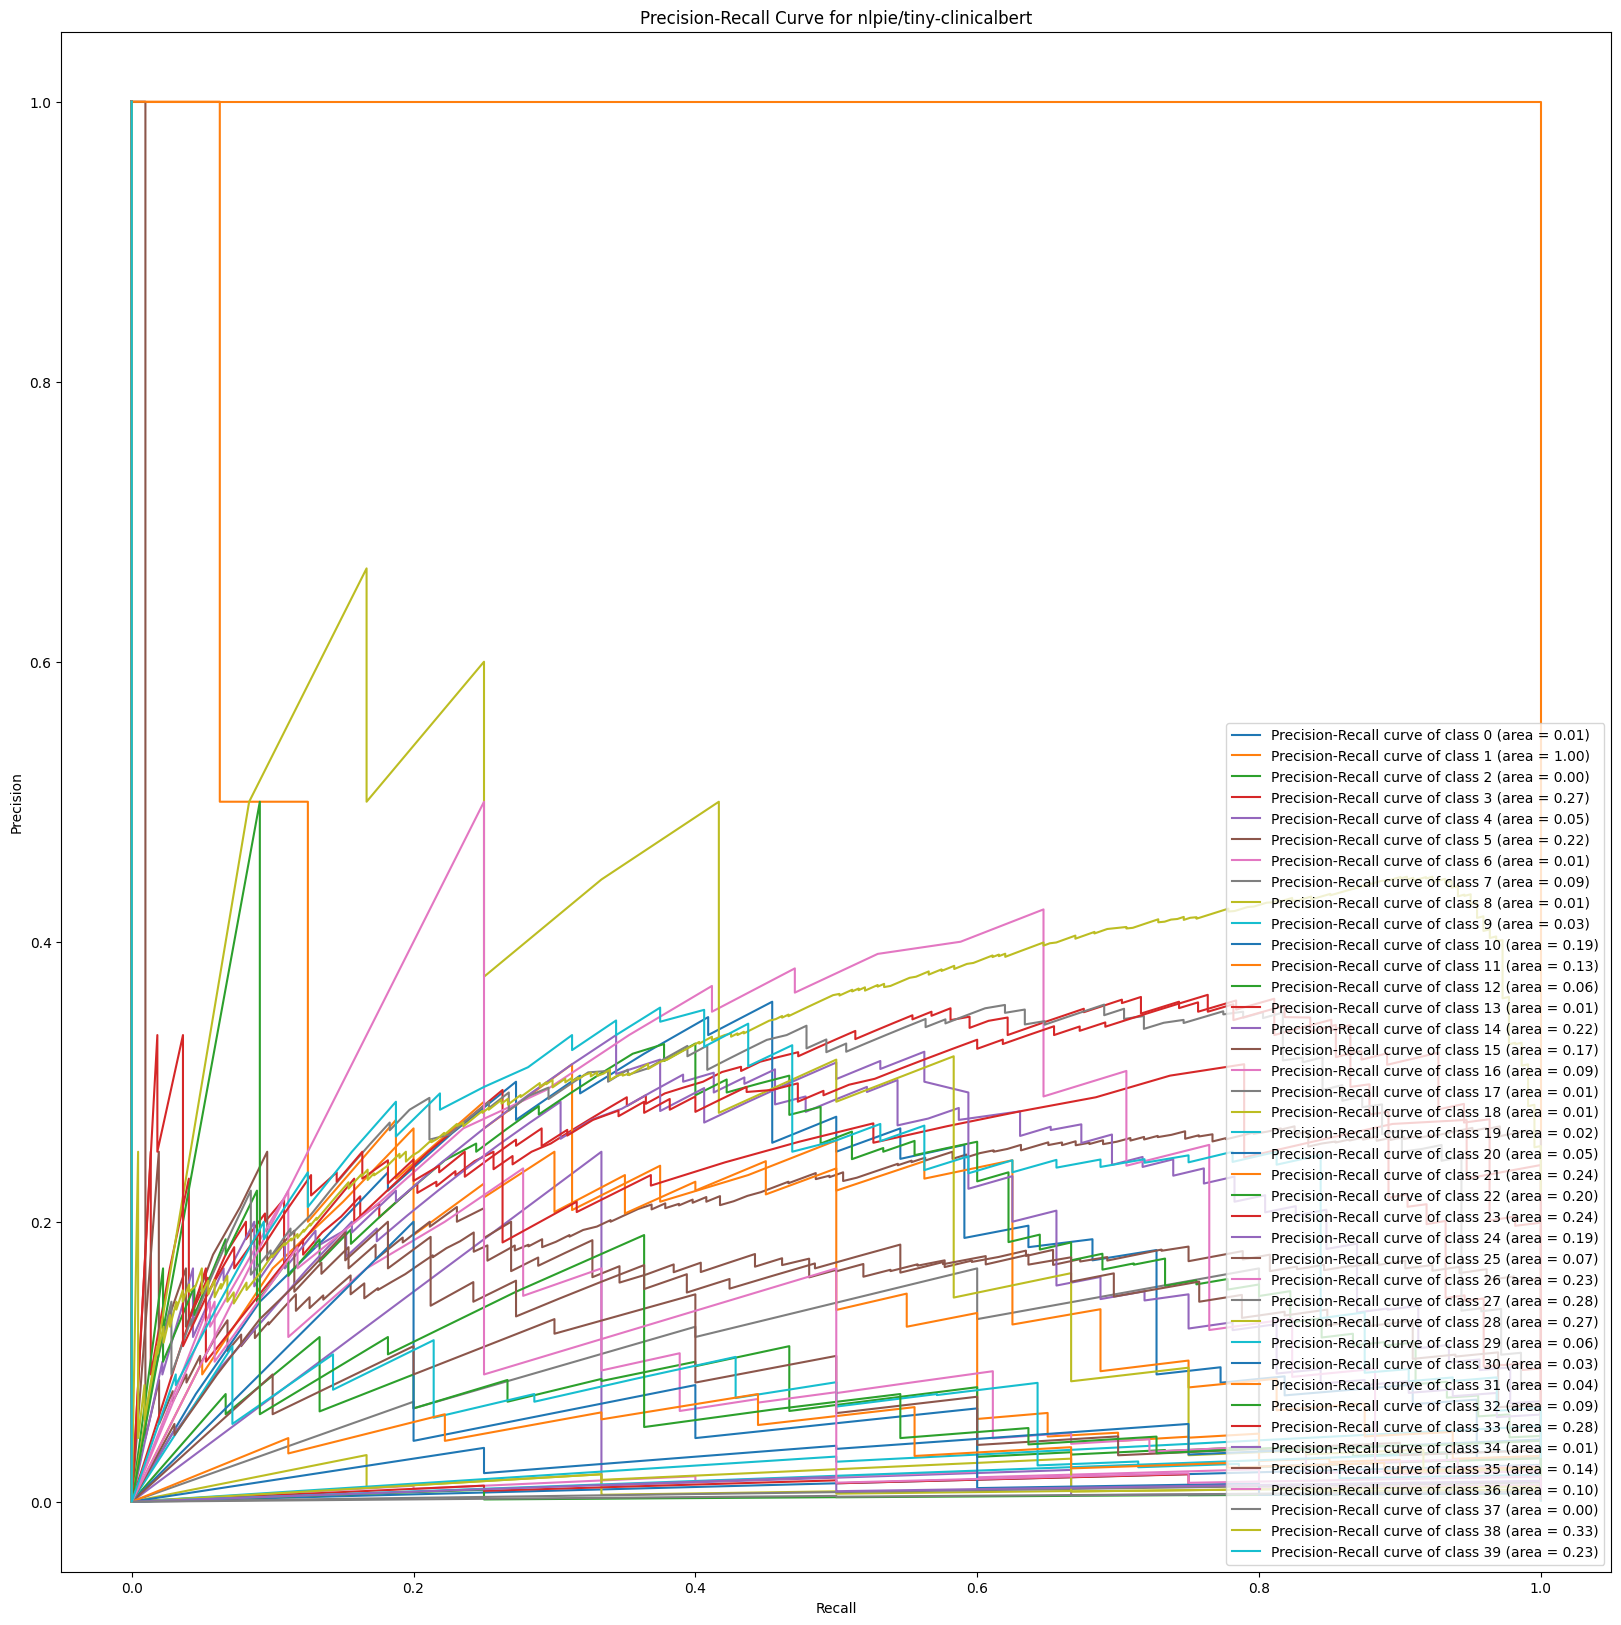


Metrics for nlpie/tiny-clinicalbert:
{'eval_loss': 2.117561101913452, 'eval_accuracy': 0.256, 'eval_precision': 0.2149398367727997, 'eval_recall': 0.256, 'eval_f1': 0.21967643713359233, 'eval_runtime': 1.2085, 'eval_samples_per_second': 827.49, 'eval_steps_per_second': 52.132, 'epoch': 13.0}


In [10]:
if __name__ == "__main__":
    main("nlpie/tiny-clinicalbert")

tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/distil-clinicalbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for nlpie/distil-clinicalbert:
{'eval_loss': 1.8116657733917236, 'eval_accuracy': 0.323, 'eval_precision': 0.31832878481624255, 'eval_recall': 0.323, 'eval_f1': 0.2948581420333938, 'eval_runtime': 3.1269, 'eval_samples_per_second': 319.805, 'eval_steps_per_second': 20.148, 'epoch': 6.0}
Confusion Matrix for nlpie/distil-clinicalbert:
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 95 20]
 [ 0  0  0 ...  0  5 22]]

Classification Report for nlpie/distil-clinicalbert:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.33      0.42      0.37        74
           4       0.00      0.00      0.00         3
           5       0.24      0.40      0.30       103
           6       0.00      0.00      0.00         5
           7 

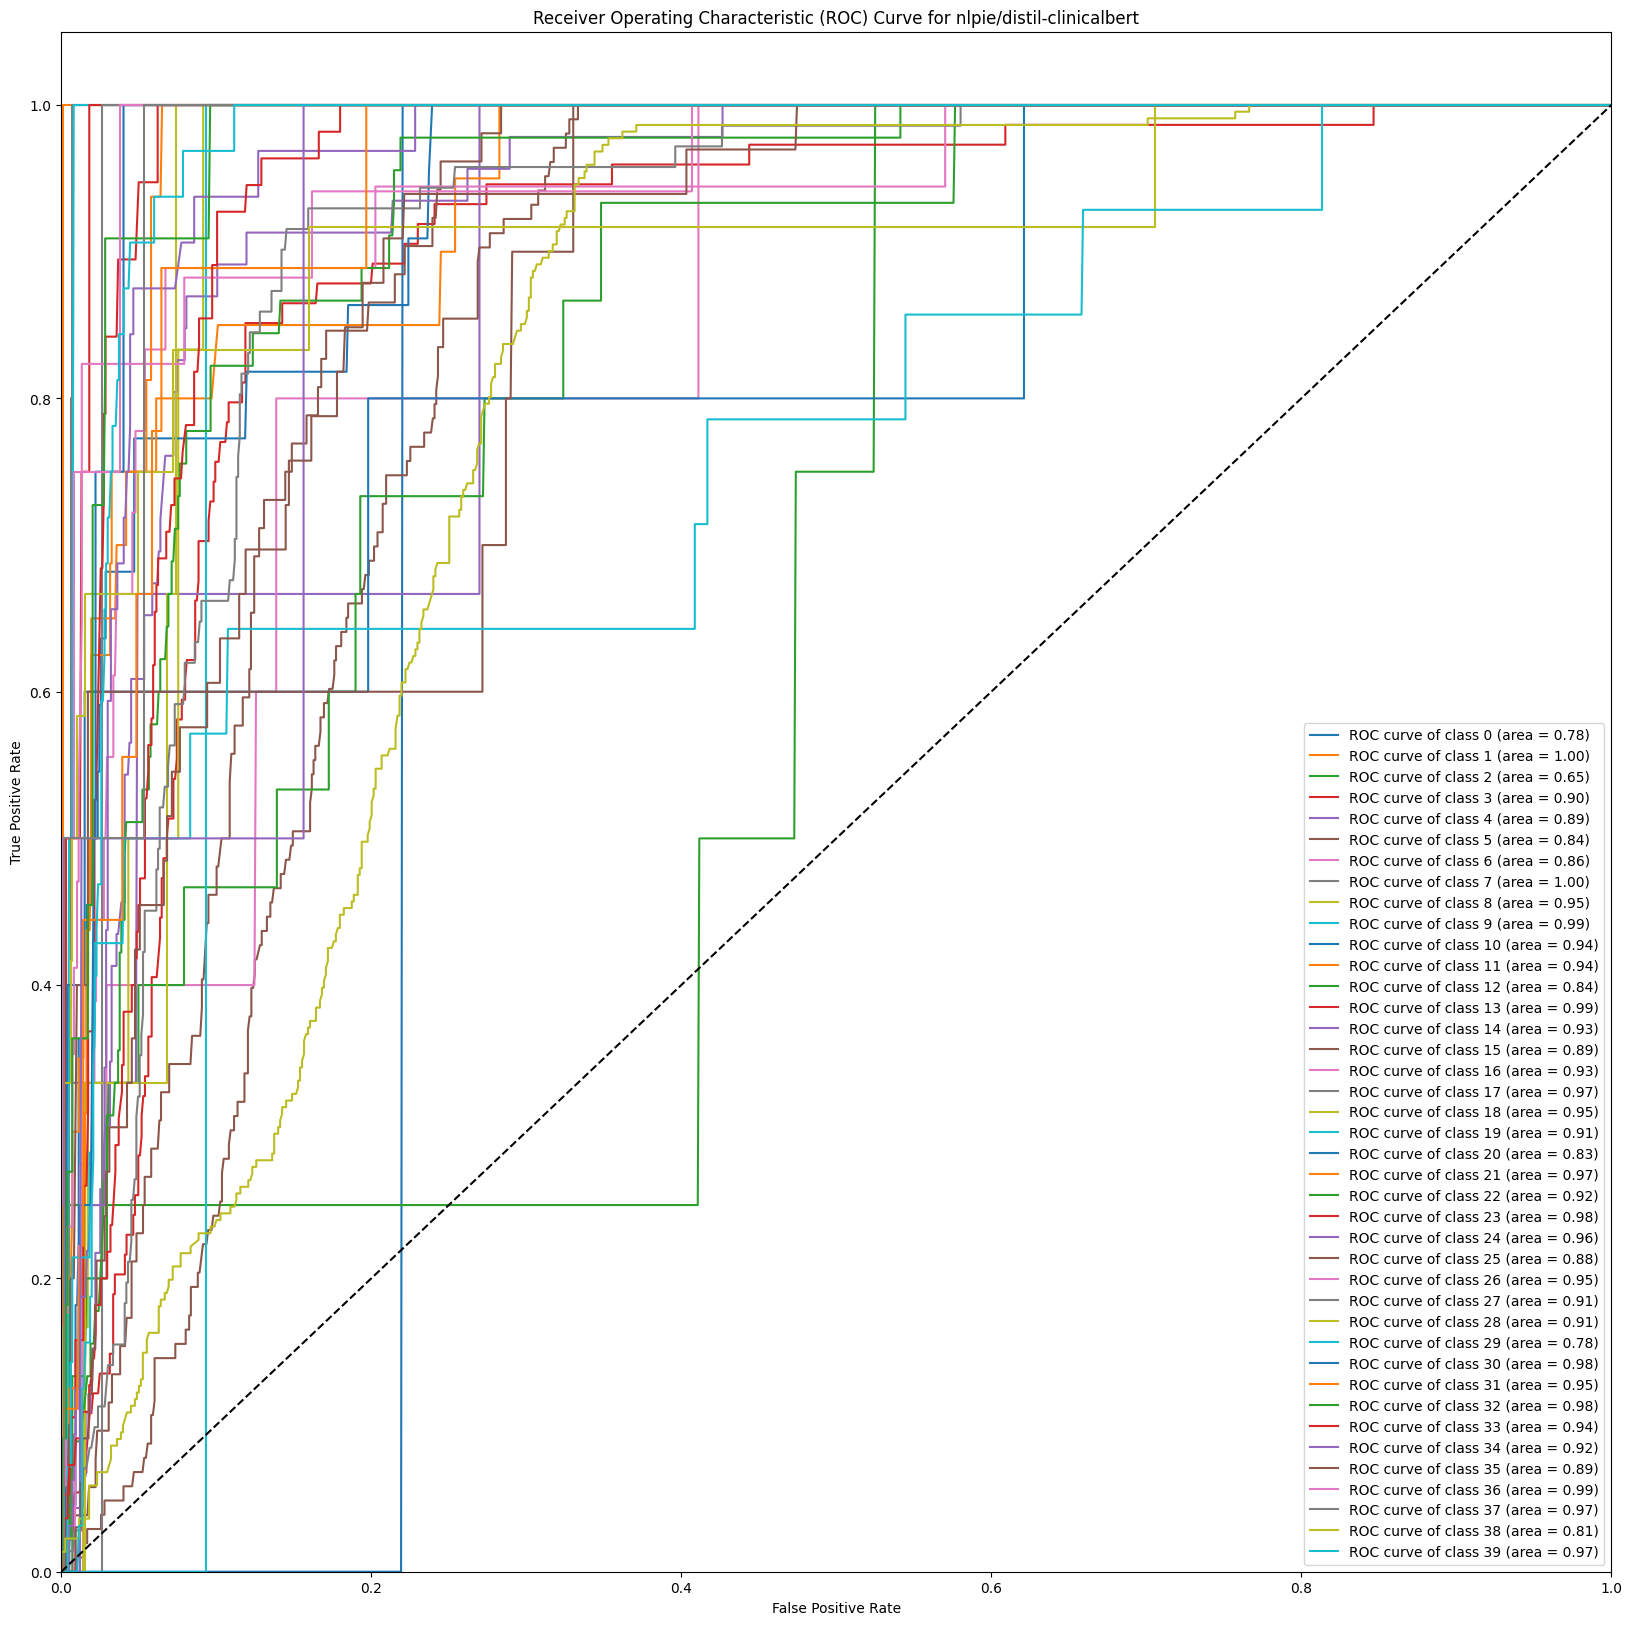

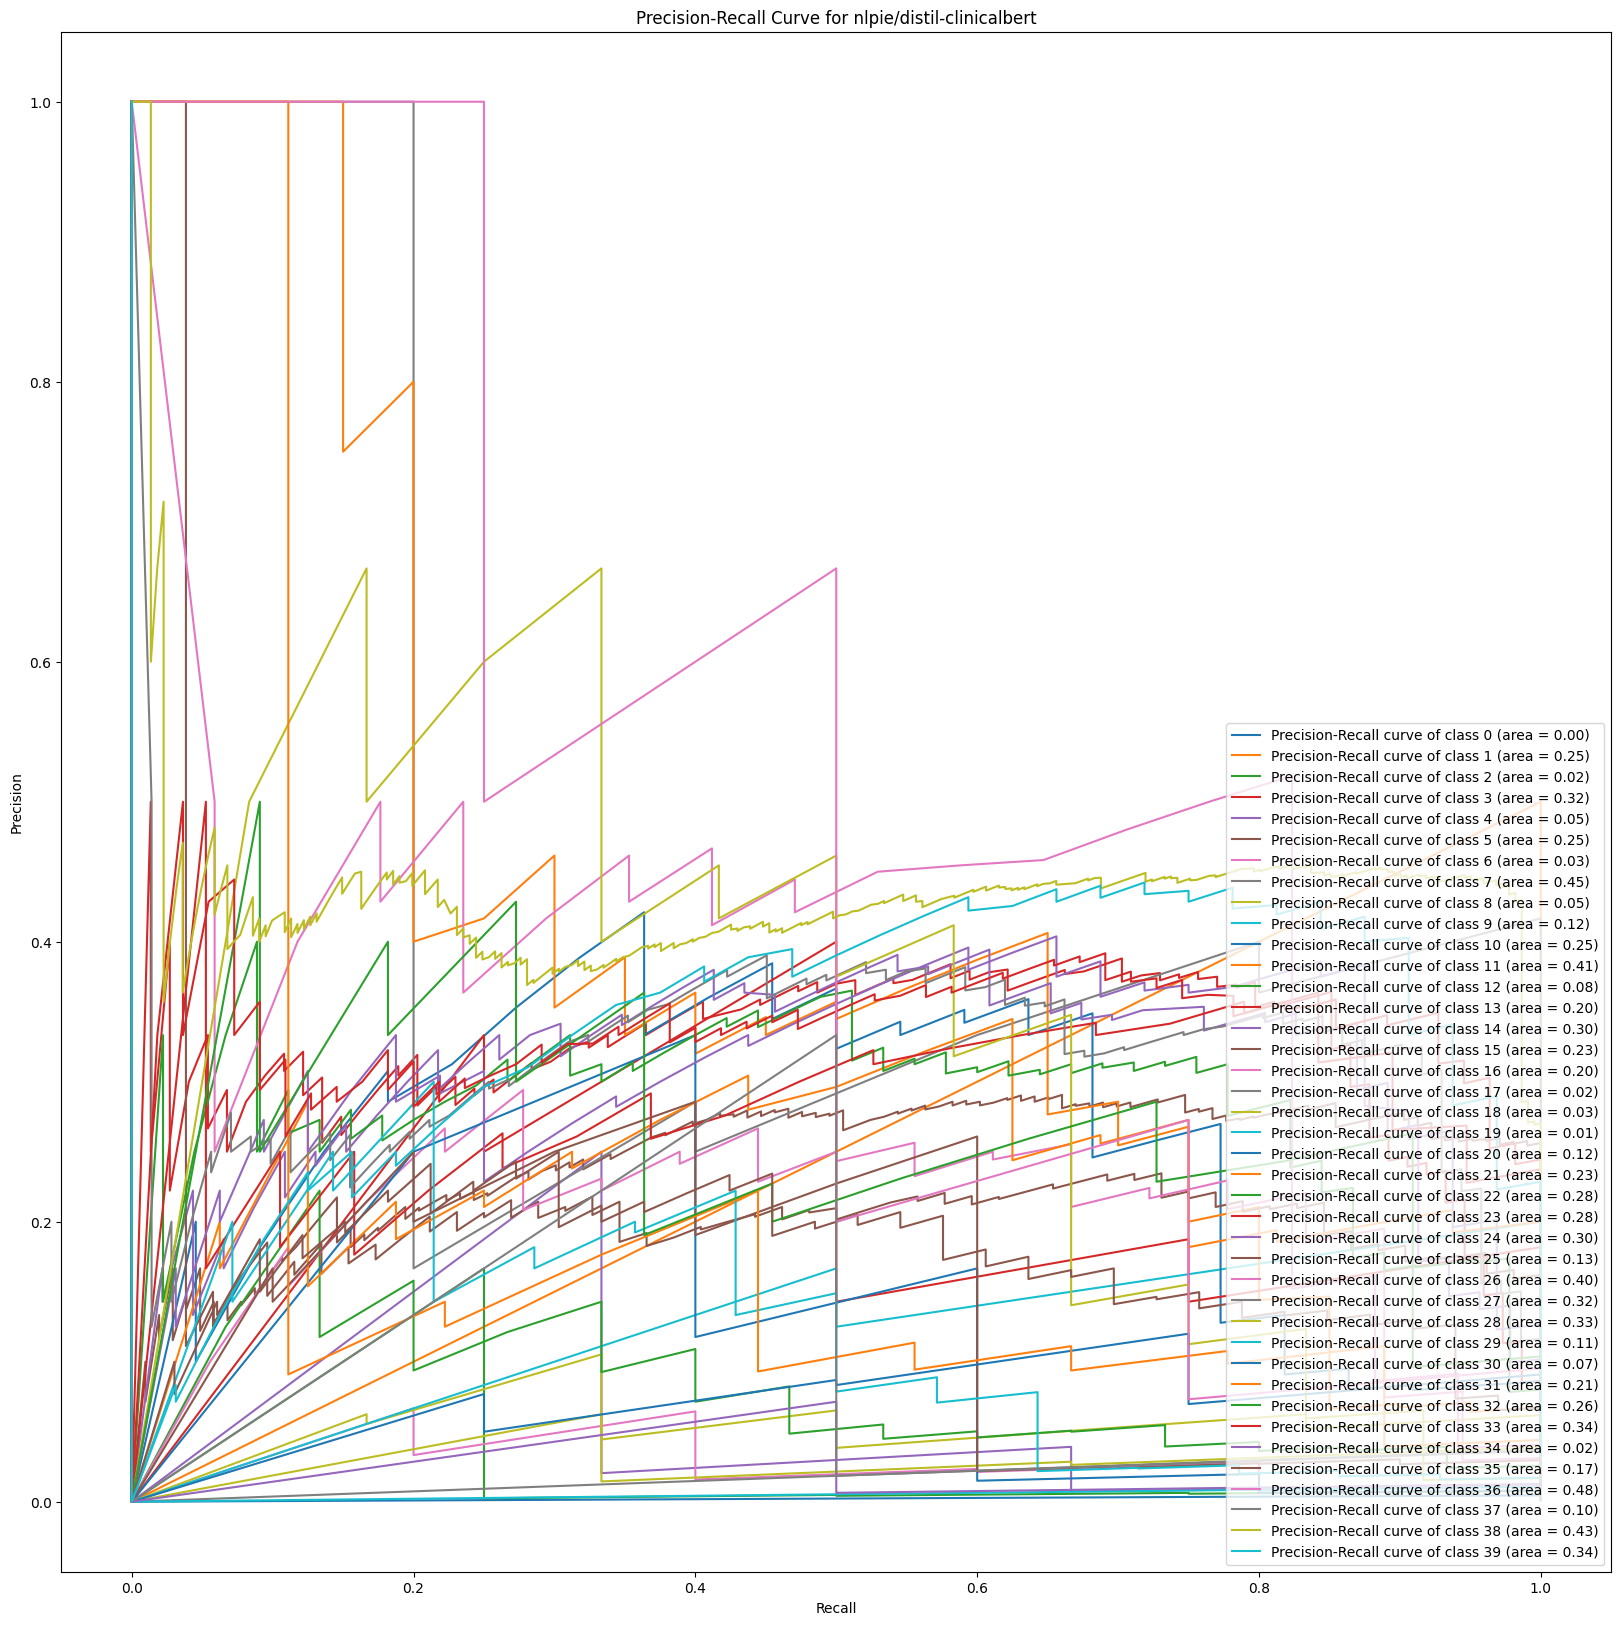


Metrics for nlpie/distil-clinicalbert:
{'eval_loss': 1.8116657733917236, 'eval_accuracy': 0.323, 'eval_precision': 0.31832878481624255, 'eval_recall': 0.323, 'eval_f1': 0.2948581420333938, 'eval_runtime': 3.1269, 'eval_samples_per_second': 319.805, 'eval_steps_per_second': 20.148, 'epoch': 6.0}


In [11]:
if __name__ == "__main__":
    main('nlpie/distil-clinicalbert')

tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/987 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/164M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/clinical-miniALBERT-312 and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.

Metrics for nlpie/clinical-miniALBERT-312:
{'eval_loss': 2.224095106124878, 'eval_accuracy': 0.256, 'eval_precision': 0.21148455257673338, 'eval_recall': 0.256, 'eval_f1': 0.22602528178250855, 'eval_runtime': 3.1852, 'eval_samples_per_second': 313.953, 'eval_steps_per_second': 19.779, 'epoch': 10.0}
Confusion Matrix for nlpie/clinical-miniALBERT-312:
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  3  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 92  9]
 [ 0  0  0 ...  0 17  3]]

Classification Report for nlpie/clinical-miniALBERT-312:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.23      0.24      0.23        74
           4       0.00      0.00      0.00         3
           5       0.21      0.34      0.26       103
           6       0.00      0.00      0.00         5


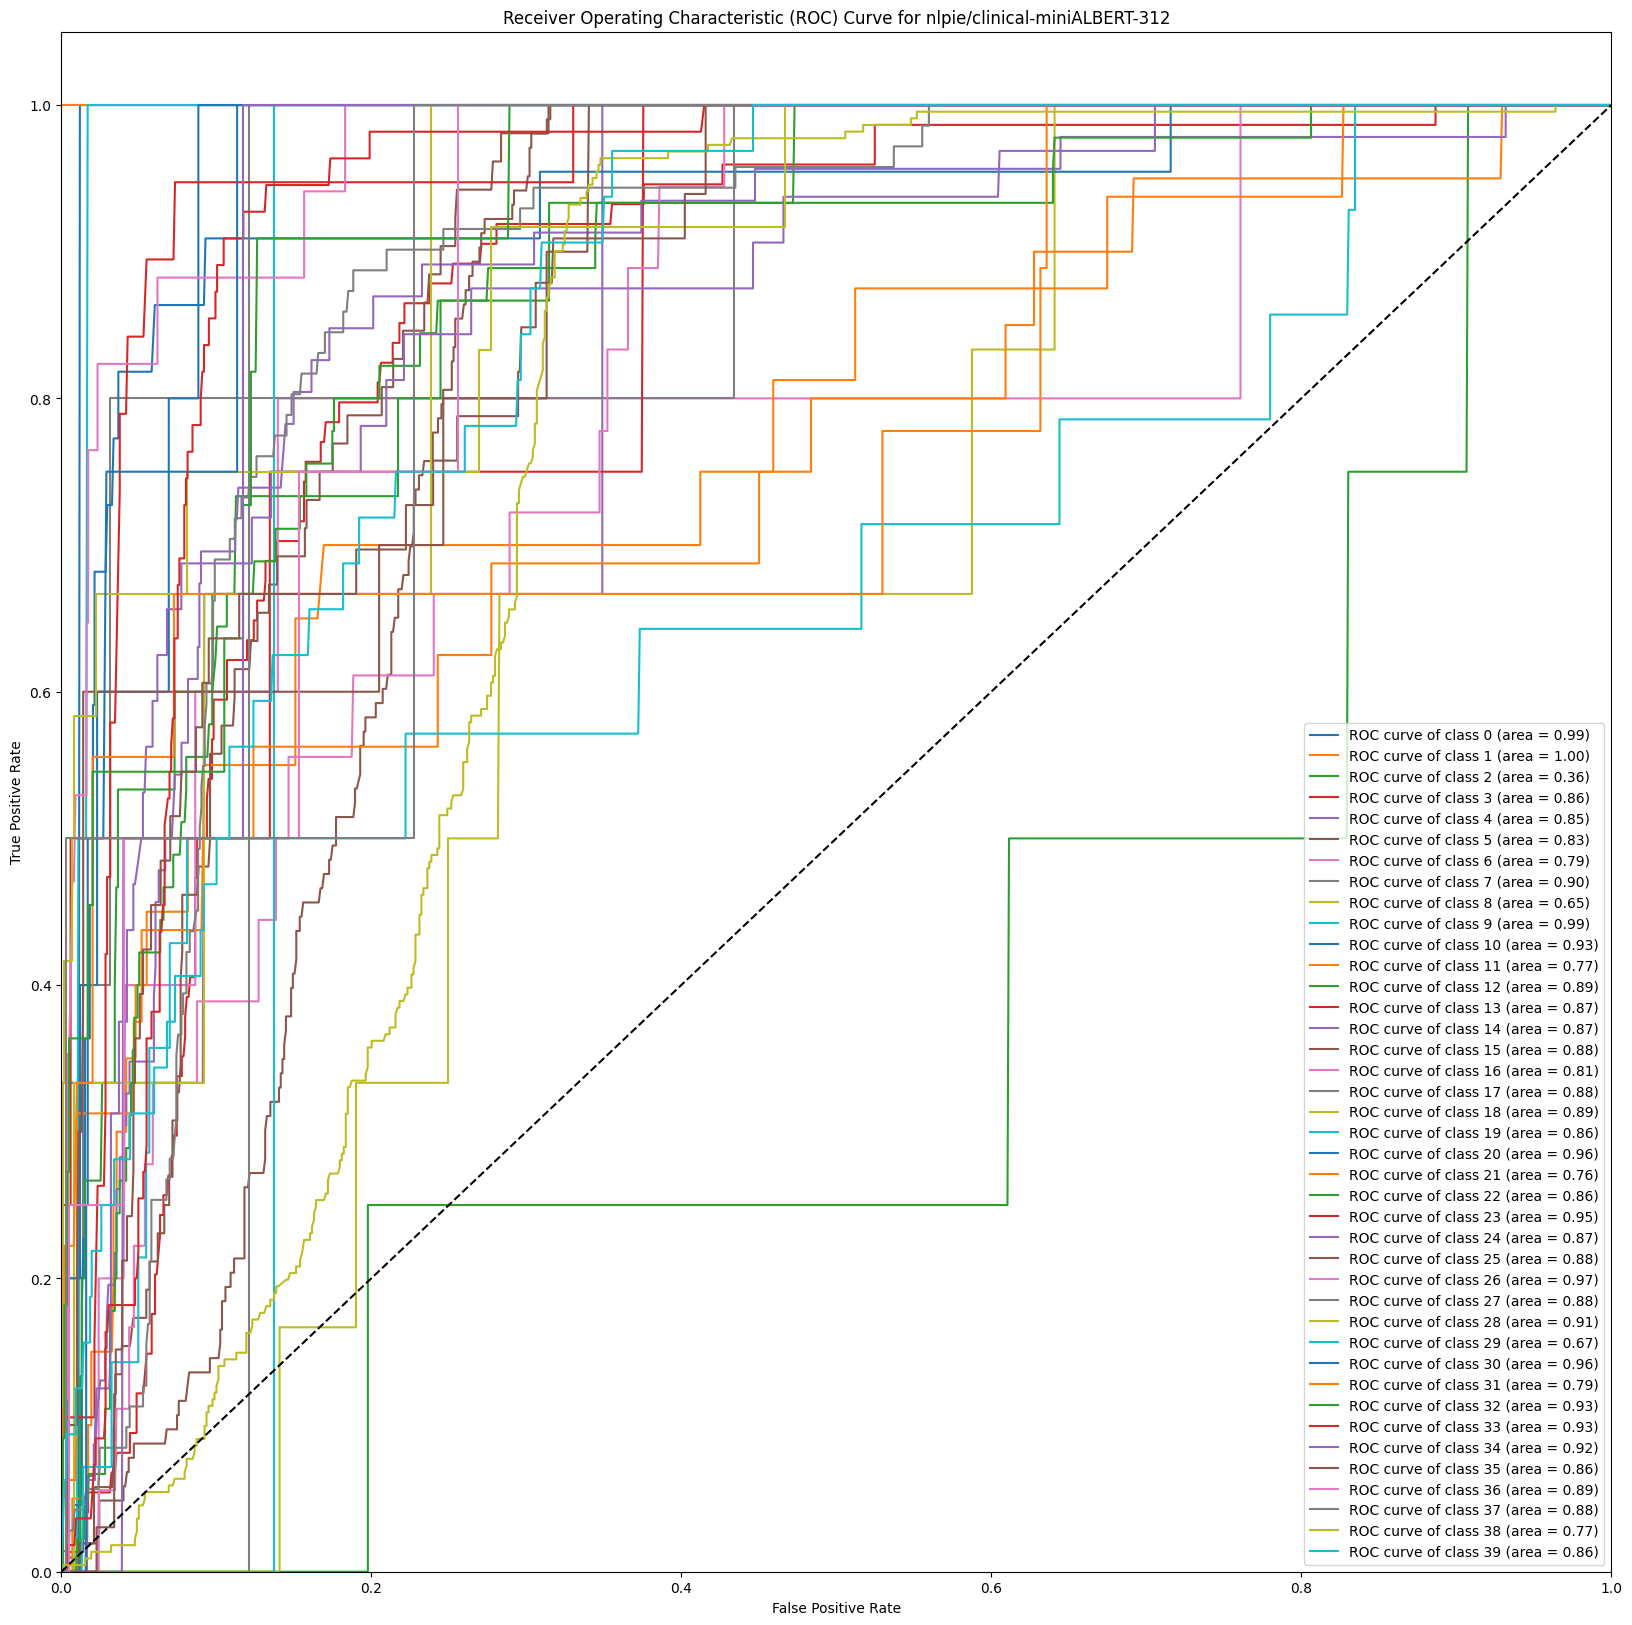

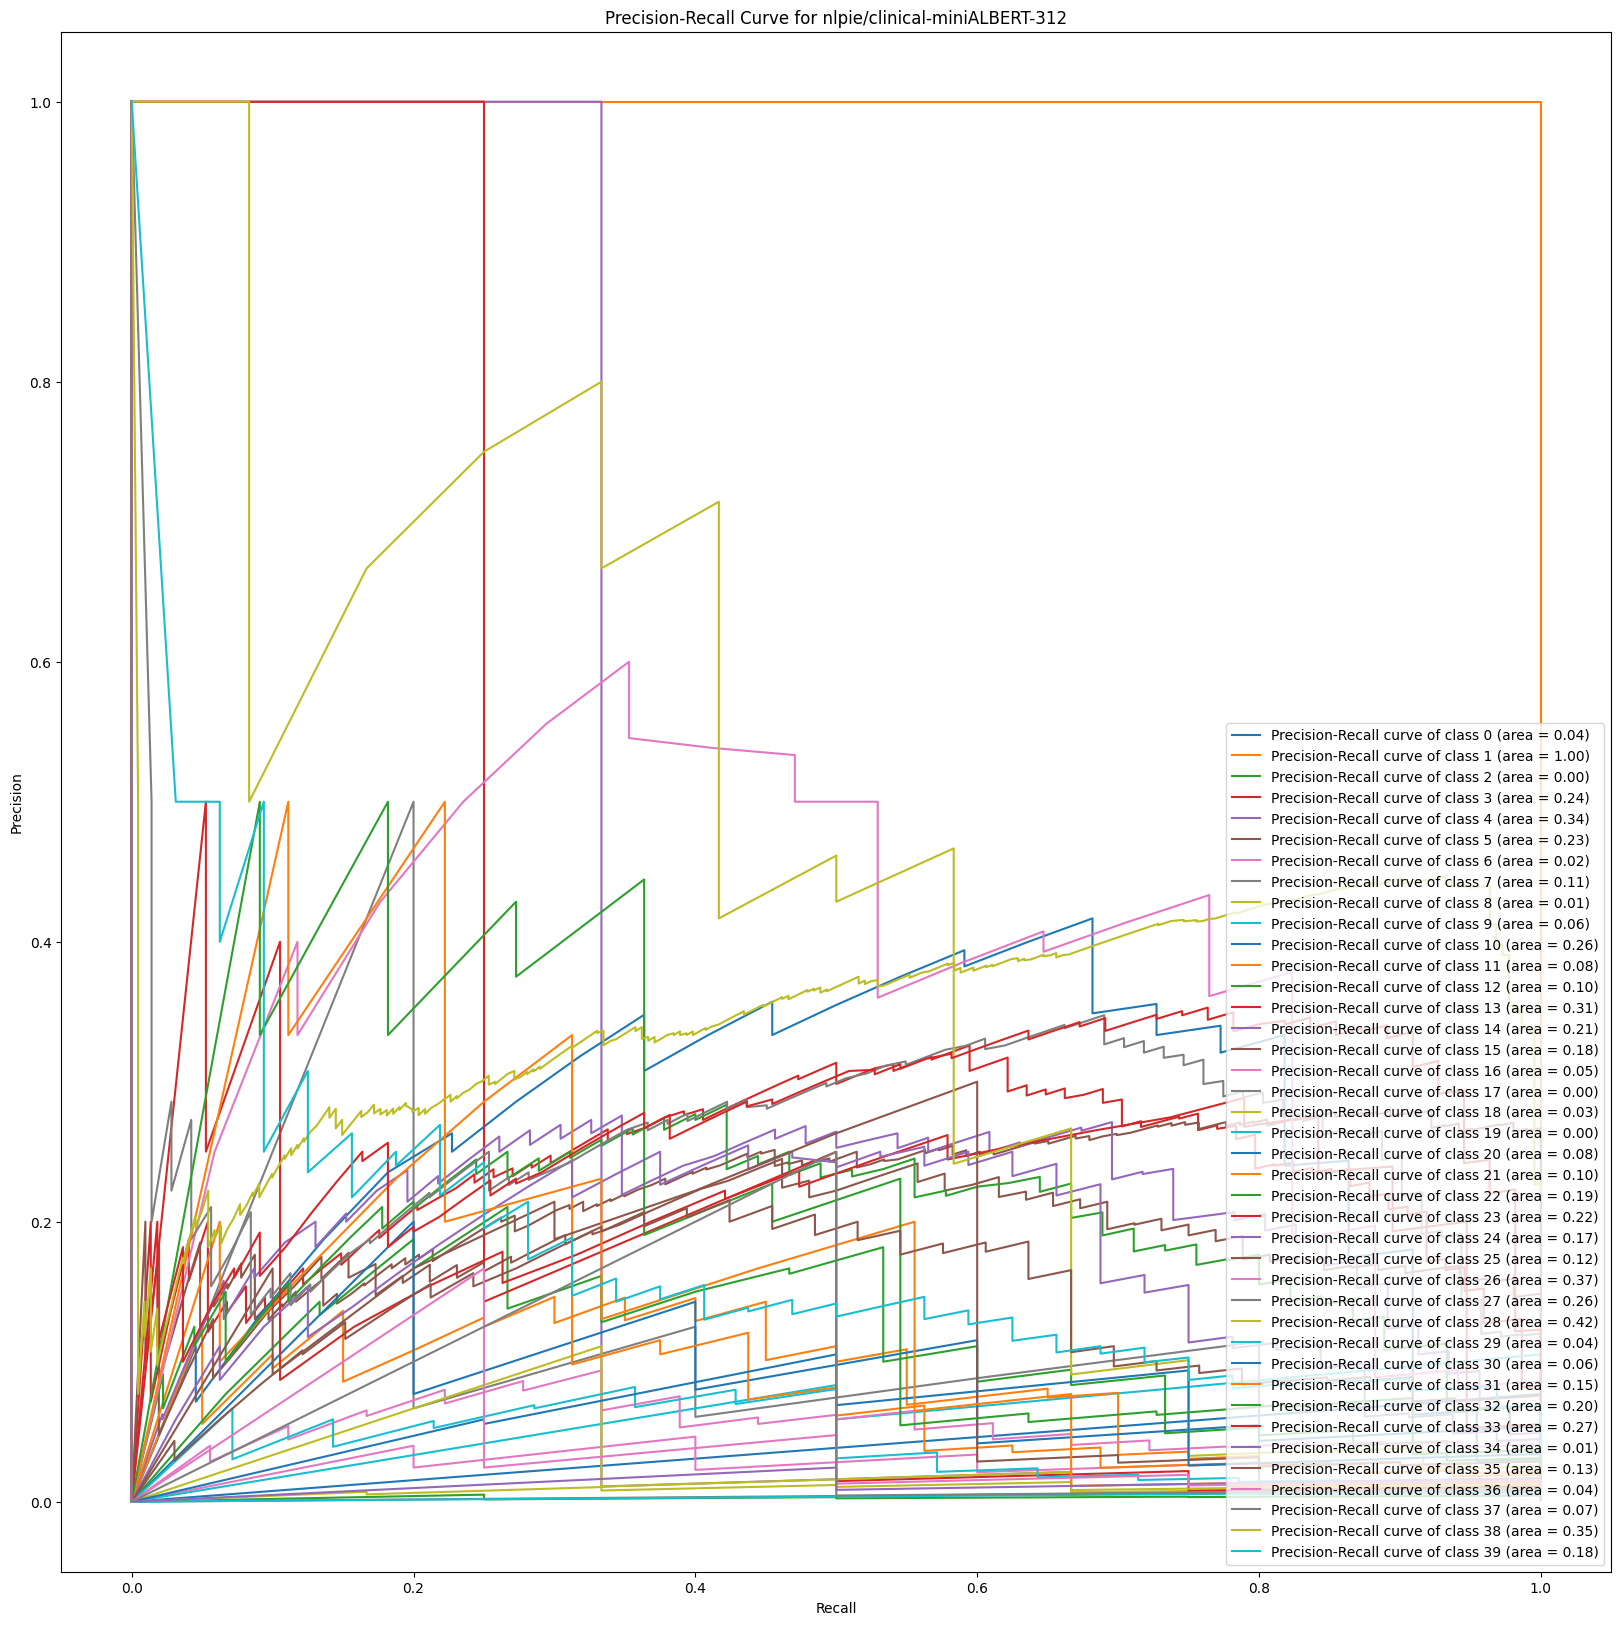


Metrics for nlpie/clinical-miniALBERT-312:
{'eval_loss': 2.224095106124878, 'eval_accuracy': 0.256, 'eval_precision': 0.21148455257673338, 'eval_recall': 0.256, 'eval_f1': 0.22602528178250855, 'eval_runtime': 3.1852, 'eval_samples_per_second': 313.953, 'eval_steps_per_second': 19.779, 'epoch': 10.0}


In [12]:
if __name__ == "__main__":
    main('nlpie/clinical-miniALBERT-312')